In [1]:
import gc
gc.collect()

3

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sns
sns.set()
from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
import string
import os
import time
from PIL import Image
import glob
from pickle import dump, load
from time import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import nltk

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#images='../input/flickr-image-dataset/flickr30k_images/flickr30k_images'
#text_file='../input/flickr-image-dataset/flickr30k_images/results.csv'

images='/content/drive/MyDrive/Eye_For_Blind/dataset/images'
# text_file='../input/flickr8k/captions.txt'
text_file ='/content/drive/MyDrive/Eye_For_Blind/dataset/captions.txt'

In [5]:
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 1917


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

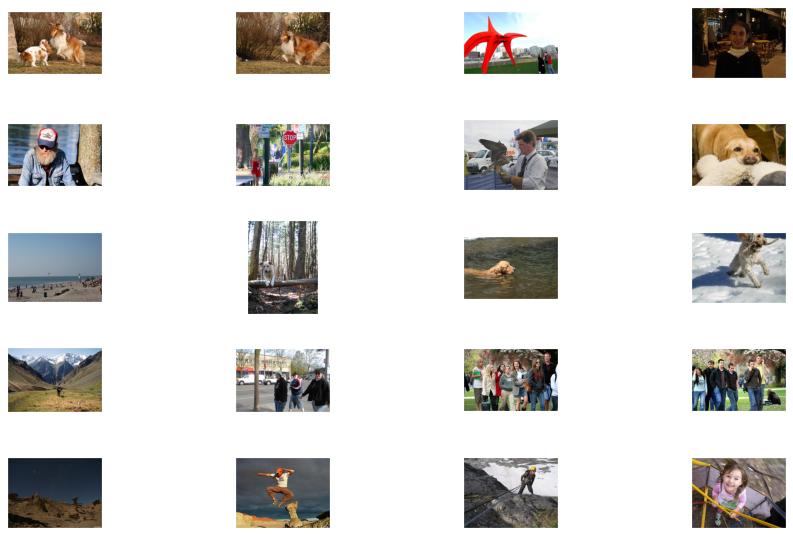

In [7]:
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mpimg.imread(all_imgs[i]));

In [8]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [9]:
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [10]:
# #/ this is for flickr30k dataset operation/
# all_img_id=[]
# all_img_vector=[]
# annotations=[]
# f=open(text_file,"r")
# for line in f.readlines()[1:]:
#     img_id=line.split('|',1)[0]
#     cap=line.split('|')[-1]
#     all_img_id.append(img_id)
#     all_img_vector.append(images+'/'+img_id)
#     annotations.append(cap.split('\n')[0])

#     #print(img_id,cap)
# limit = 100000
# all_img_id = all_img_id[:limit]
# all_img_vector = all_img_vector[:limit]
# annotations=annotations[:limit]
# df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
# df

In [11]:
#/ this is for flickr8k dataset operation/

all_img_id=[]
all_img_vector=[]
annotations=[]
f=open(text_file,"r")
for line in f.readlines()[1:]:
    img_id, cap = line.split(',', 1)
    img_id=img_id.split('.')[0]
    if os.path.exists(images+'/'+img_id+'.jpg'):
      all_img_id.append(img_id)
      all_img_vector.append(images+'/'+img_id+'.jpg')
      annotations.append(cap.split('\n')[0])
    
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A black dog and a spotted dog are fighting
1,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A black dog and a tri-colored dog playing with...
2,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A black dog and a white dog with brown spots a...
3,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,Two dogs of different breeds looking at each o...
4,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,Two dogs on pavement moving toward each other .
...,...,...,...
9580,997722733_0cb5439472,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A man in a pink shirt climbs a rock face
9581,997722733_0cb5439472,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A man is rock climbing high in the air .
9582,997722733_0cb5439472,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A person in a red shirt climbing up a rock fac...
9583,997722733_0cb5439472,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A rock climber in a red shirt .


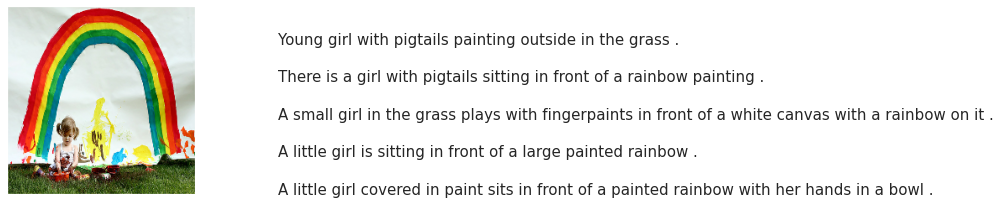

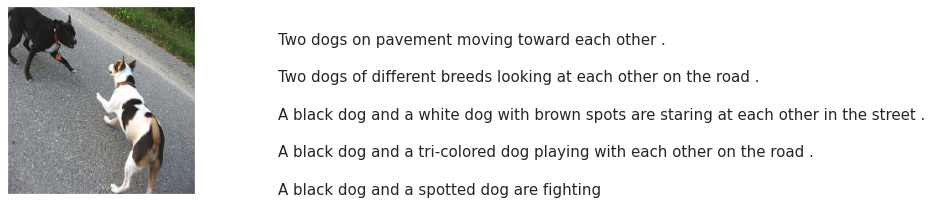

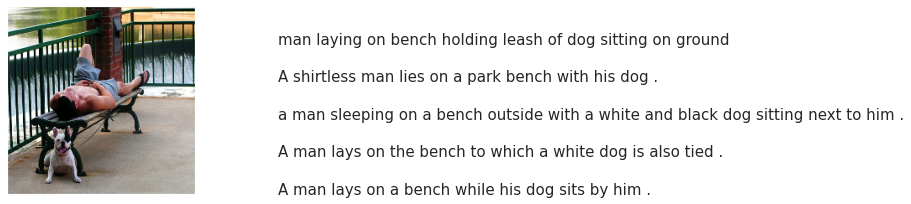

In [12]:
img_path=list(set(df.Path[:15]))
count = 1
j=0
for path in img_path:
  if os.path.exists(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
      
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(img)
    

    count += 1
      
    ax = fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,5)
    
    img_cap=df.loc[df['Path'] == path, 'Captions']
    
    for i in range(len(img_cap)):
        ax.text(0,i,img_cap.iloc[i],fontsize=15)
    count += 1
    j+=1
plt.show()


    
    

In [13]:
annotations=[]
for cap in df.Captions:
    cap='<start> '+ cap + ' <end>'
    annotations.append(cap)
annotations

['<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>',
 '<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>',
 '<start> A little girl is sitting in front of a large painted rainbow . <end>',
 '<start> A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . <end>',
 '<start> There is a girl with pigtails sitting in front of a rainbow painting . <end>',
 '<start> Young girl with pigtails painting outside in the grass . <end>',
 '<start> A man lays on a bench while his dog sits by him . <end>',
 '<start> A man lays on the bench to which a white do

In [14]:
all_img_vector=[]
for img_path in df.Path:
    all_img_vector.append(img_path)

all_img_vector

['/content/drive/MyDrive/Eye_For_Blind/dataset/images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1003163366_44323f5815.jpg',
 '/content/drive/MyDrive/Eye_For_Blind/dataset/images/1003163366_44323f5815.jpg',
 '/content/drive

In [15]:
def gen_vocabulary():
    vocab = []
    for cap in df.Captions.values:
        vocab.extend(cap.split())
    print("Size of vocabulary: {}".format(len(set(vocab))))
    return vocab

In [16]:
vocabulary=gen_vocabulary()

Size of vocabulary: 4776


In [17]:
val_count=Counter(vocabulary)
val_count

Counter({'A': 5163,
         'black': 953,
         'dog': 2296,
         'and': 1981,
         'a': 9539,
         'spotted': 9,
         'are': 738,
         'fighting': 40,
         'tri-colored': 2,
         'playing': 469,
         'with': 1966,
         'each': 91,
         'other': 180,
         'on': 2559,
         'the': 3765,
         'road': 112,
         '.': 8073,
         'white': 932,
         'brown': 671,
         'spots': 8,
         'staring': 16,
         'at': 680,
         'in': 4572,
         'street': 272,
         'Two': 967,
         'dogs': 540,
         'of': 1627,
         'different': 12,
         'breeds': 2,
         'looking': 179,
         'pavement': 11,
         'moving': 12,
         'toward': 39,
         'little': 366,
         'girl': 748,
         'covered': 74,
         'paint': 11,
         'sits': 169,
         'front': 351,
         'painted': 18,
         'rainbow': 12,
         'her': 281,
         'hands': 47,
         'bowl': 14,
       

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Text(0.5, 1.0, 'Top 30 occurinng words')

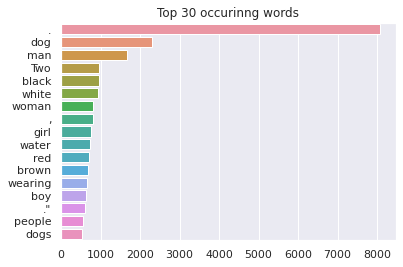

In [19]:
sort_lst = val_count.most_common(30)
stop=set(stopwords.words('english'))
x, y=[], []
for word,count in sort_lst:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)
            
sns.barplot(x=y,y=x).set_title('Top 30 occurinng words')

In [20]:
os.makedirs('/content/drive/MyDrive/Eye_For_Blind/output/kaggle/working/files')
# /content/drive/MyDrive/Eye_For_Blind/output/kaggle/working/files

In [21]:
!ls

drive  sample_data


In [22]:
import pickle
def save_obj(obj, name ):
    with open('/content/drive/MyDrive/Eye_For_Blind/output/kaggle/working/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open('/content/drive/MyDrive/Eye_For_Blind/output/kaggle/working/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [23]:
save_obj(df, "dataframe")

In [24]:
df=load_obj('dataframe')
df

,ID,Path,Captions
0,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A black dog and a spotted dog are fighting
1,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A black dog and a tri-colored dog playing with...
2,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A black dog and a white dog with brown spots a...
3,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,Two dogs of different breeds looking at each o...
4,1001773457_577c3a7d70,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,Two dogs on pavement moving toward each other .
...,...,...,...
9580,997722733_0cb5439472,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A man in a pink shirt climbs a rock face
9581,997722733_0cb5439472,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A man is rock climbing high in the air .
9582,997722733_0cb5439472,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A person in a red shirt climbing up a rock fac...
9583,997722733_0cb5439472,/content/drive/MyDrive/Eye_For_Blind/dataset/i...,A rock climber in a red shirt .


In [25]:
import gc
gc.collect()

340

In [26]:
image_model = keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

base_model = keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


In [27]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [28]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

In [29]:
from tqdm.notebook import tqdm

encode_train = sorted(set(all_img_vector))

feature_dict = {}


image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)


In [30]:
len(encode_train)

1917

In [31]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
  batch_features = base_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    feature_dict[path_of_feature] =  bf.numpy()

100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


In [32]:
bf.shape

TensorShape([64, 2048])

In [33]:
import gc
gc.collect()
len(feature_dict)

1917

In [34]:
top_k = 5000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

train_seqs = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [35]:
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'in': 5,
 'the': 6,
 'on': 7,
 'dog': 8,
 'is': 9,
 'and': 10,
 'with': 11,
 'man': 12,
 'of': 13,
 'two': 14,
 'black': 15,
 'white': 16,
 'woman': 17,
 ',': 18,
 'girl': 19,
 'to': 20,
 'are': 21,
 'water': 22,
 'red': 23,
 'brown': 24,
 'at': 25,
 'wearing': 26,
 'boy': 27,
 'people': 28,
 'an': 29,
 'dogs': 30,
 'young': 31,
 'blue': 32,
 'running': 33,
 'his': 34,
 'through': 35,
 'ball': 36,
 'playing': 37,
 'grass': 38,
 'down': 39,
 'while': 40,
 'standing': 41,
 'shirt': 42,
 'snow': 43,
 'little': 44,
 'sitting': 45,
 'walking': 46,
 'field': 47,
 'front': 48,
 'small': 49,
 'person': 50,
 'up': 51,
 'large': 52,
 'child': 53,
 'over': 54,
 'rock': 55,
 'mouth': 56,
 'its': 57,
 'holding': 58,
 'three': 59,
 'by': 60,
 'jumping': 61,
 'green': 62,
 'near': 63,
 'yellow': 64,
 'her': 65,
 'street': 66,
 'football': 67,
 'beach': 68,
 'stands': 69,
 'from': 70,
 'into': 71,
 'one': 72,
 'out': 73,
 'group': 74,
 'men': 75,
 'an

In [36]:
annotations[:5]

['<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>']

In [37]:
train_seqs[:5]

[[3, 2, 15, 8, 10, 2, 821, 8, 21, 273, 4],
 [3, 2, 15, 8, 10, 2, 1920, 312, 8, 37, 11, 156, 90, 7, 6, 132, 4],
 [3, 2, 15, 8, 10, 2, 16, 8, 11, 24, 897, 21, 562, 25, 156, 90, 5, 6, 66, 4],
 [3, 14, 30, 13, 676, 1921, 91, 25, 156, 90, 7, 6, 132, 4],
 [3, 14, 30, 7, 727, 677, 283, 156, 90, 4]]

In [38]:
tokenizer.word_counts

OrderedDict([('<start>', 9585),
             ('a', 15035),
             ('black', 989),
             ('dog', 2343),
             ('and', 1983),
             ('spotted', 9),
             ('are', 738),
             ('fighting', 41),
             ('<end>', 9585),
             ('tri', 2),
             ('colored', 35),
             ('playing', 469),
             ('with', 1968),
             ('each', 91),
             ('other', 180),
             ('on', 2563),
             ('the', 4478),
             ('road', 116),
             ('white', 952),
             ('brown', 706),
             ('spots', 8),
             ('staring', 16),
             ('at', 681),
             ('in', 4578),
             ('street', 278),
             ('two', 1355),
             ('dogs', 549),
             ('of', 1632),
             ('different', 12),
             ('breeds', 2),
             ('looking', 180),
             ('pavement', 11),
             ('moving', 12),
             ('toward', 39),
             ('little', 

Text(0.5, 1.0, 'Top 30 occurinng words')

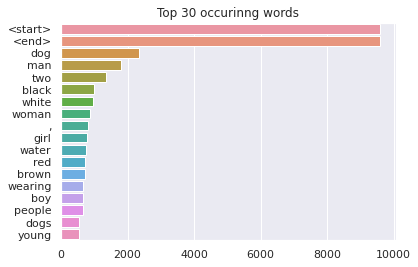

In [39]:
sorted_by_word_count = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
x, y=[], []
for word,count in sorted_by_word_count[:30]:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)
            
sns.barplot(x=y,y=x).set_title('Top 30 occurinng words')

In [40]:
def calc_max_length(tensor):
    max_t=max(len(t) for t in tensor)
    print("The maximum length of a sentence in the annotation dataset is: " + str(max_t) )
    return max_t

In [41]:
max_length = calc_max_length(train_seqs)
cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The maximum length of a sentence in the annotation dataset is: 35
The shape of Caption vector is :(9585, 35)


In [42]:
img_train, img_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [43]:
print("Training data for images: " + str(len(img_train)))
print("Testing data for images: " + str(len(img_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 7668
Testing data for images: 1917
Training data for Captions: 7668
Testing data for Captions: 1917


In [44]:
save_obj(img_train, "img_train")
save_obj(cap_train, "cap_train")
save_obj(img_test, "img_test")
save_obj(cap_test, "cap_test")

In [45]:
def map_func(img_name, cap):
  img_tensor = feature_dict[img_name.decode('utf-8')]
  return img_tensor, cap

In [46]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
train_num_steps = len(img_train) // BATCH_SIZE
test_num_steps = len(img_test) // BATCH_SIZE
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

In [47]:
def gen_dataset(img_data, cap_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [48]:
train_dataset=gen_dataset(img_train,cap_train)
test_dataset=gen_dataset(img_test,cap_test)

In [49]:
dataset = train_dataset.take(1)
for img,cap in dataset:
  print(img.shape)
  print(cap.shape)

(32, 64, 2048)
(32, 35)


In [50]:
class CNN_Encoder(keras.Model):

    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = layers.Dense(embedding_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

encoder = CNN_Encoder(embedding_dim)



In [51]:
class Attention_model(keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self,features,hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [52]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [53]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 64, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # shape: (batch_size, 1, hidden_size)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) #shape: (batch_size, 64, units)
        attention_weights = keras.activations.softmax(self.V(score), axis=1) #shape: (batch_size, 64, 1)
        context_vector = attention_weights * features #shape: (batch_size, 64,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)#shape: (batch_size, embedding_dim)
        

        return context_vector, attention_weights
    

In [54]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=True)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)
        self.dropout = Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) #shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) #shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed,mask=mask) # output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
decoder=Decoder(embedding_dim, units, vocab_size)

In [55]:
attention=Attention_model(units)

In [56]:
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
attention=Attention_model(units)

In [57]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) 
print(sample_cap_batch.shape)

(32, 64, 2048)
(32, 35)


In [58]:
features=encoder(sample_img_batch)
features.shape

TensorShape([32, 64, 256])

In [59]:
features=encoder(sample_img_batch)

hidden = decoder.reset_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
print(hidden.shape)
print(dec_input.shape)

(32, 512)
(32, 1)


In [60]:
dummy_dataset = train_dataset.take(1)
for img,cap in dummy_dataset:
    features=encoder(img)
    hidden = decoder.reset_state(batch_size=cap.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * cap.shape[0], 1)
    context_vector, attention_weights=attention(features, hidden)
    predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
    print(features.shape)
    print(predictions.shape)
    print(attention_weights.shape)
    print(context_vector.shape)

(32, 64, 256)
(32, 5001)
(32, 64, 1)
(32, 256)


In [61]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = keras.optimizers.Adam()

In [62]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [63]:
# os.makedirs('../output/kaggle/working/checkpoints/train')
os.makedirs('/content/drive/MyDrive/Eye_For_Blind/output/kaggle/working/checkpoints/train')

In [64]:
# checkpoint_path = "..working/checkpoints/train"
checkpoint_path = "/content/drive/MyDrive/Eye_For_Blind/output/kaggle/working/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [65]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [66]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
        
  avg_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, avg_loss

In [67]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
        
  avg_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, avg_loss

In [68]:
def test_loss_cal(test_dataset):
    
  total_loss = 0
  for (batch, (img_tensor, target)) in enumerate(test_dataset):
    # batch_loss, t_loss = test_step(img_tensor, target)
    batch_loss, t_loss = train_step(img_tensor, target)
    
    total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
  return avg_test_loss

In [69]:
loss_plot = []
test_loss_plot = []
gc.collect()

353

In [70]:
import time

In [71]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
      print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
      best_test_loss = test_loss
      ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.685, & test loss is 1.423
Time taken for 1 epoch 116.42182397842407 sec

Test loss has been reduced from 100.000 to 1.423


  7%|▋         | 1/15 [01:56<27:14, 116.77s/it]

For epoch: 2, the train loss is 1.288, & test loss is 1.204
Time taken for 1 epoch 25.94258713722229 sec

Test loss has been reduced from 1.423 to 1.204


 13%|█▎        | 2/15 [02:22<13:45, 63.48s/it] 

For epoch: 3, the train loss is 1.129, & test loss is 1.070
Time taken for 1 epoch 25.919503927230835 sec

Test loss has been reduced from 1.204 to 1.070


 20%|██        | 3/15 [02:49<09:17, 46.44s/it]

For epoch: 4, the train loss is 1.016, & test loss is 0.970
Time taken for 1 epoch 25.885428428649902 sec

Test loss has been reduced from 1.070 to 0.970


 27%|██▋       | 4/15 [03:15<07:02, 38.42s/it]

For epoch: 5, the train loss is 0.926, & test loss is 0.887
Time taken for 1 epoch 25.897016525268555 sec

Test loss has been reduced from 0.970 to 0.887


 33%|███▎      | 5/15 [03:41<05:39, 33.99s/it]

For epoch: 6, the train loss is 0.847, & test loss is 0.812
Time taken for 1 epoch 25.852081060409546 sec

Test loss has been reduced from 0.887 to 0.812


 40%|████      | 6/15 [04:07<04:41, 31.31s/it]

For epoch: 7, the train loss is 0.780, & test loss is 0.747
Time taken for 1 epoch 25.816446542739868 sec

Test loss has been reduced from 0.812 to 0.747


 47%|████▋     | 7/15 [04:33<03:56, 29.60s/it]

For epoch: 8, the train loss is 0.726, & test loss is 0.691
Time taken for 1 epoch 25.779443502426147 sec

Test loss has been reduced from 0.747 to 0.691


 53%|█████▎    | 8/15 [04:59<03:19, 28.46s/it]

For epoch: 9, the train loss is 0.669, & test loss is 0.640
Time taken for 1 epoch 25.781479597091675 sec

Test loss has been reduced from 0.691 to 0.640


 60%|██████    | 9/15 [05:25<02:46, 27.71s/it]

For epoch: 10, the train loss is 0.619, & test loss is 0.593
Time taken for 1 epoch 25.751097440719604 sec

Test loss has been reduced from 0.640 to 0.593


 67%|██████▋   | 10/15 [05:51<02:15, 27.18s/it]

For epoch: 11, the train loss is 0.575, & test loss is 0.549
Time taken for 1 epoch 25.896088361740112 sec

Test loss has been reduced from 0.593 to 0.549


 73%|███████▎  | 11/15 [06:17<01:47, 26.87s/it]

For epoch: 12, the train loss is 0.537, & test loss is 0.508
Time taken for 1 epoch 25.913758039474487 sec

Test loss has been reduced from 0.549 to 0.508


 80%|████████  | 12/15 [06:43<01:19, 26.65s/it]

For epoch: 13, the train loss is 0.498, & test loss is 0.472
Time taken for 1 epoch 25.928358554840088 sec

Test loss has been reduced from 0.508 to 0.472


 87%|████████▋ | 13/15 [07:10<00:53, 26.51s/it]

For epoch: 14, the train loss is 0.461, & test loss is 0.440
Time taken for 1 epoch 25.88187336921692 sec

Test loss has been reduced from 0.472 to 0.440


 93%|█████████▎| 14/15 [07:36<00:26, 26.40s/it]

For epoch: 15, the train loss is 0.435, & test loss is 0.408
Time taken for 1 epoch 25.844680547714233 sec

Test loss has been reduced from 0.440 to 0.408


100%|██████████| 15/15 [08:02<00:00, 32.16s/it]


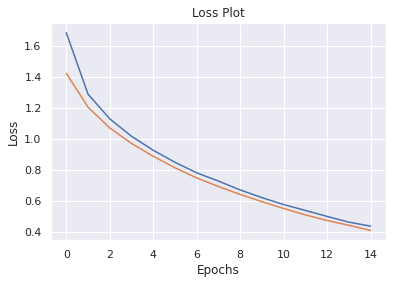

In [72]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [73]:
# os.listdir("..working/checkpoints/train")
os.listdir("/content/drive/MyDrive/Eye_For_Blind/output/kaggle/working/checkpoints/train")

['checkpoint',
 'ckpt-11.data-00000-of-00001',
 'ckpt-11.index',
 'ckpt-12.data-00000-of-00001',
 'ckpt-12.index',
 'ckpt-13.data-00000-of-00001',
 'ckpt-13.index',
 'ckpt-14.data-00000-of-00001',
 'ckpt-14.index',
 'ckpt-15.data-00000-of-00001',
 'ckpt-15.index']

In [74]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = base_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [75]:
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = base_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption



In [76]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [78]:
# checkpoint_path = "..working/checkpoints/train/ckpt-5"
checkpoint_path = "/content/drive/MyDrive/Eye_For_Blind/output/kaggle/working/checkpoints/train/ckpt-15"
   
ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
ckpt.restore(checkpoint_path)

In [79]:
from nltk.translate.bleu_score import sentence_bleu

In [80]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 53.40709061500022
Real Caption: two people in red outfits riding their bicycles down a dirt road
Prediction Caption: two people riding their bikes down a dirt road


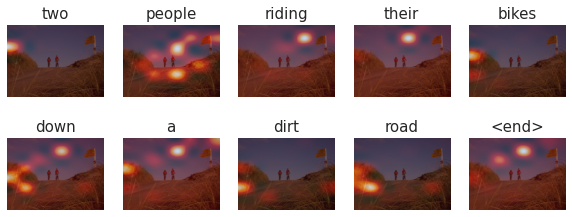

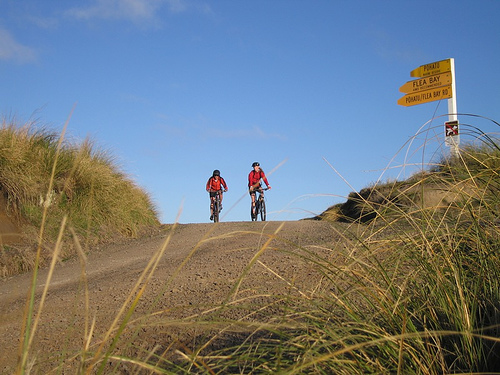

In [81]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './dataset/Flickr8k/Flicker8k_Dataset/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [82]:
captions=beam_evaluate(test_image)
print(captions)

two people


In [83]:
!pip install gtts ### google text to speech library
!pip install playsound ## playsound to play the file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=79d56b0f5b8ca997608cc2da10569cf9eef887abc3379119a24469fc68850127
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


In [84]:
from gtts import gTTS 
from playsound import playsound  

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [85]:
tts = gTTS(text=captions, lang="en", slow=False)
tts.save('/content/drive/MyDrive/Eye_For_Blind/output/speak/tts.mp3')
# playsound('/content/drive/MyDrive/Eye_For_Blind/output/speak/tts.mp3')

In [86]:
!pip install pygobject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
playsound('/content/drive/MyDrive/Eye_For_Blind/output/speak/tts.mp3')